# **Assignment 4**
**Submitted by** : Ritu Gahir

**Team Members** :


*   Ritu Gahir - Group 3

*   Libin Kutty - Group 2

*   Viju Sudhi - Group 10




# **CNN on CIFAR10 with tf.function**

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.regularizers import l2
import time

In [0]:
cifar_10 = tf.keras.datasets.cifar10
(train_images_cifar, train_labels_cifar), (test_images_cifar, test_labels_cifar) = cifar_10.load_data()

train_labels_cifar=train_labels_cifar.reshape((-1,))
test_labels_cifar =test_labels_cifar.reshape((-1,))


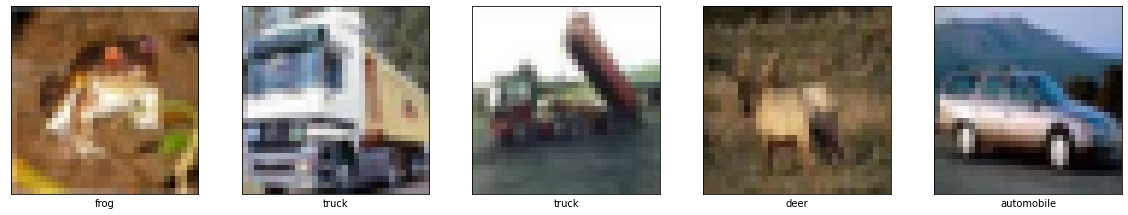

In [0]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images_cifar[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels_cifar[i]])
plt.show()

In [0]:
data_cifar = tf.data.Dataset.from_tensor_slices(
    (train_images_cifar.reshape([-1,32,32,3]).astype(np.float32) / 255, train_labels_cifar.astype(np.int32)))
train_data_cifar = data_cifar.shuffle(buffer_size=60000).batch(128).repeat(3)

# note: we batch the test data, but do not shuffle/repeat
test_data_cifar = tf.data.Dataset.from_tensor_slices(
    (test_images_cifar.reshape([-1,32,32,3]).astype(np.float32)/ 255, test_labels_cifar.astype(np.int32))).batch(128)

#.reshape([-1,28,28,1]).astype(np.float32)

print (train_data_cifar)

<RepeatDataset shapes: ((None, 32, 32, 3), (None,)), types: (tf.float32, tf.int32)>


In [0]:
#Model 
n_h = 256
model_cifar=tf.keras.models.Sequential(
    [
     tf.keras.layers.Conv2D(32 , (3,3) , activation='relu',kernel_initializer='he_uniform', padding='same',input_shape=(32,32,3)), #kernel_regularizer=l2(0.001)
     tf.keras.layers.Conv2D(32 , (3,3) , activation='relu',kernel_initializer='he_uniform',padding='same'),
     tf.keras.layers.MaxPooling2D(2,2),
     tf.keras.layers.Dropout(0.2),

     #tf.keras.layers.Conv2D(64 , (3,3) , activation='relu',kernel_initializer='he_uniform',padding='same'),#,kernel_regularizer=l2(0.001) ),
     #tf.keras.layers.Conv2D(64 , (3,3) , activation='relu',kernel_initializer='he_uniform',padding='same'),#,kernel_regularizer=l2(0.001)),
     #tf.keras.layers.MaxPooling2D(2,2),
     #tf.keras.layers.Dropout(0.2),

     #tf.keras.layers.Conv2D(128 , (3,3), activation='relu',kernel_initializer='he_uniform',padding='same'),#kernel_regularizer=l2(0.001)),
     #tf.keras.layers.Conv2D(128 , (3,3) , activation='relu',kernel_initializer='he_uniform',padding='same'),
     #tf.keras.layers.MaxPooling2D(2,2),
     #tf.keras.layers.Dropout(0.2),

     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(128 , activation=tf.nn.relu,kernel_initializer='he_uniform'),#,kernel_regularizer=l2(0.001)),#kernel_regularizer=l2(0.001) Regularisation
     tf.keras.layers.Dropout(0.2),
     tf.keras.layers.Dense(n_h//2 , activation=tf.nn.relu),
    
     tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])
model_cifar.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_381 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_382 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

In [0]:
optimizer_cifar = keras.optimizers.SGD(lr=0.001, momentum=0.9)
loss_fn_cifar = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [0]:
train_acc_metric_cifar = keras.metrics.SparseCategoricalAccuracy()
test_acc_metric_cifar = keras.metrics.SparseCategoricalAccuracy()

In [0]:
@tf.function
def train_step(train_data, train_labels):
    with tf.GradientTape() as tape:
      logits = model_cifar(x_batch_train_cifar, training=True)
      loss_value = loss_fn_cifar(y_batch_train_cifar, logits)

    grads = tape.gradient(loss_value, model_cifar.trainable_weights)
    optimizer_cifar.apply_gradients(zip(grads, model_cifar.trainable_weights))
    train_acc_metric_cifar(y_batch_train_cifar, logits)

    return loss_value, logits

In [0]:
import datetime

epochs = 5
print("start time :" , datetime.datetime.now().time())

for epoch in range(epochs):
  tf.print('Start of epoch %d' % (epoch,))
  start = time.time()
  for step, (x_batch_train_cifar, y_batch_train_cifar) in enumerate(train_data_cifar):

    loss_value, logits = train_step(x_batch_train_cifar, y_batch_train_cifar)

    # Log every 200 batches.
    if step % 500 == 0:
      
        tf.print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
        #tf.print('Seen so far: %s samples' % ((step + 1) * 64))
        stop = time.time()
        tf.print("took {} seconds\n".format(stop-start))
        start = time.time()

  train_acc_cifar = train_acc_metric_cifar.result()
  tf.print('Training acc over epoch: %s' % (float(train_acc_cifar),))

print("end time ",datetime.datetime.now().time())
 

start time : 08:06:38.616690
Start of epoch 0
Training loss (for one batch) at step 0: 1.4824010133743286
took 1.0550599098205566 seconds

Training loss (for one batch) at step 500: 1.4779245853424072
took 39.23673963546753 seconds

Training loss (for one batch) at step 1000: 1.4776318073272705
took 39.180898666381836 seconds

Training acc over epoch: 0.9832733273506165
Start of epoch 1
Training loss (for one batch) at step 0: 1.477031946182251
took 0.8185074329376221 seconds

Training loss (for one batch) at step 500: 1.4771450757980347
took 39.25257754325867 seconds

Training loss (for one batch) at step 1000: 1.4771212339401245
took 39.326350688934326 seconds

Training acc over epoch: 0.9833466410636902
Start of epoch 2
Training loss (for one batch) at step 0: 1.4774656295776367
took 0.7922494411468506 seconds

Training loss (for one batch) at step 500: 1.4768023490905762
took 39.25463056564331 seconds

Training loss (for one batch) at step 1000: 1.4764349460601807
took 39.467490434

In [0]:
for x_batch_test_cifar, y_batch_test_cifar in test_data_cifar:
  test_logits = model_cifar(x_batch_test_cifar)
    # Update val metrics
  test_acc_metric_cifar(y_batch_test_cifar, test_logits)
test_acc_cifar = test_acc_metric_cifar.result()
#test_acc_metric_cifar.reset_states()
tf.print('Test acc: %s' % (float(test_acc_cifar),))

**Observations :**

---

*   Without annotation : start time : 20:44:53.047836      end time  20:46:08.999409     duration : 1 minute 16 seconds

*   With annotation : start time : 20:49:42.303946        end time end time  20:50:17.490376      duration : 35 seconds




















# **Densenet with CIFAR-10**

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from keras.regularizers import l2
#from tensorflow.contrib.layers import  batch_norm,flatten
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate

In [0]:
cifar_10 = tf.keras.datasets.cifar10
(train_images_cifar, train_labels_cifar), (test_images_cifar, test_labels_cifar) = cifar_10.load_data()

train_labels_cifar=train_labels_cifar.reshape((-1,))
test_labels_cifar =test_labels_cifar.reshape((-1,))


In [0]:
data_cifar = tf.data.Dataset.from_tensor_slices(
    (train_images_cifar.reshape([-1,32,32,3]).astype(np.float32) / 255, train_labels_cifar.astype(np.int32)))
train_data_cifar = data_cifar.shuffle(buffer_size=60000).batch(128).repeat(3)

# note: we batch the test data, but do not shuffle/repeat
test_data_cifar = tf.data.Dataset.from_tensor_slices(
    (test_images_cifar.reshape([-1,32,32,3]).astype(np.float32)/ 255, test_labels_cifar.astype(np.int32))).batch(128)

#.reshape([-1,28,28,1]).astype(np.float32)

print (train_data_cifar)

<RepeatDataset shapes: ((None, 32, 32, 3), (None,)), types: (tf.float32, tf.int32)>


In [0]:
#@tf.function

def rl_conv(x, filters, kernel_size):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters=filters,kernel_size=kernel_size,padding='same',kernel_regularizer=l2(0.001))(x)  #number of filters and kernel size
    x = tf.keras.layers.Dropout(0.2)(x)
    return x

In [0]:
#@tf.function

def dense_block(tensor, k, reps):     #input tensor after maxpool , k=filters for convolution , reps : how many times the conv operation is applied 
    for _ in range(reps):
        #x = rl_conv(tensor, filters=4*k, kernel_size=1)  #4 filters with 1X1
        x = rl_conv(tensor, filters=k, kernel_size=3)  # filters defined for dense block are 1x1 and 3x3 but we are using only 6x6
        tensor = Concatenate()([tensor, x])
    return tensor

In [0]:
#@tf.function

def transition_layer(x, theta):  # x is the tensor from denseblock  ; theta is used to reduce the feature map  to half a theta=0.5
    f = int(tf.keras.backend.int_shape(x)[-1] * theta)
    x = rl_conv(x, filters=f, kernel_size=1)  # f is the number of filters // a new convolution layer is added 
    x = AvgPool2D(pool_size=2, strides=2, padding='same')(x) # average pooing is done to reduce the size
    return x

In [0]:
#Dense net model architecture

k = 12
theta = 0.5
repetitions = 6, 12, 24 ,16  # 4 dense blocks
 
input = Input(shape=(32, 32, 3))
 
x = Conv2D(32, 3, strides=2, activation='relu',padding='same',kernel_regularizer=l2(0.001))(input)
x = MaxPool2D(3, strides=2, padding='same')(x)
 
for reps in repetitions:
    d = dense_block(x, k, reps) #d is the tensor returned by dense block
    x = transition_layer(d, theta) #theta is the decay rate 
 
x = GlobalAvgPool2D()(d)  # Global average done on last Dense block instead of transition layer.
 
output = Dense(10, activation='softmax',kernel_regularizer=l2(0.001))(x)
 
from tensorflow.keras import Model 
DenseNet_cifar_model = Model(input, output)


In [0]:
from tensorflow.keras.utils import plot_model
plot_model(DenseNet_cifar_model, show_shapes=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.95617 to fit



In [0]:
optimizer_cifar = keras.optimizers.SGD(lr=0.001, momentum=0.9)
loss_fn_cifar = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [0]:
train_acc_metric_cifar = keras.metrics.SparseCategoricalAccuracy()
test_acc_metric_cifar = keras.metrics.SparseCategoricalAccuracy()

In [0]:
@tf.function
def train_step(train_data, train_labels):
    with tf.GradientTape() as tape:
      logits = DenseNet_cifar_model(x_batch_train_cifar, training=True)
      loss_value = loss_fn_cifar(y_batch_train_cifar, logits)

    grads = tape.gradient(loss_value, DenseNet_cifar_model.trainable_weights)
    optimizer_cifar.apply_gradients(zip(grads, DenseNet_cifar_model.trainable_weights))
    train_acc_metric_cifar(y_batch_train_cifar, logits)

    return loss_value, logits

In [0]:
import datetime

epochs = 10
print("start time :" , datetime.datetime.now().time())

for epoch in range(epochs):
  tf.print('Start of epoch %d' % (epoch,))
  #start = time.time()
  for step, (x_batch_train_cifar, y_batch_train_cifar) in enumerate(train_data_cifar):

    loss_value, logits = train_step(x_batch_train_cifar, y_batch_train_cifar)

    # Log every 200 batches.
    if step % 500 == 0:
      
        tf.print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
        #tf.print('Seen so far: %s samples' % ((step + 1) * 64))
        #stop = time.time()
        #tf.print("took {} seconds\n".format(stop-start))
        #start = time.time()
        train_acc_metric_cifar.reset_states()

  train_acc_cifar = train_acc_metric_cifar.result()
  tf.print('Training acc over epoch: %s' % (float(train_acc_cifar),))
  train_acc_metric_cifar.reset_states()

print("end time ",datetime.datetime.now().time())
 

start time : 08:20:24.892333
Start of epoch 0
Training loss (for one batch) at step 0: 2.301608085632324
Training loss (for one batch) at step 500: 2.125674247741699
Training loss (for one batch) at step 1000: 1.886563777923584
Training acc over epoch: 0.6025582551956177
Start of epoch 1
Training loss (for one batch) at step 0: 1.8415145874023438
Training loss (for one batch) at step 500: 1.7634148597717285
Training loss (for one batch) at step 1000: 1.74203622341156
Training acc over epoch: 0.7163146138191223
Start of epoch 2
Training loss (for one batch) at step 0: 1.7425448894500732
Training loss (for one batch) at step 500: 1.7117334604263306
Training loss (for one batch) at step 1000: 1.6227641105651855
Training acc over epoch: 0.8816460371017456
Start of epoch 3
Training loss (for one batch) at step 0: 1.6083085536956787
Training loss (for one batch) at step 500: 1.5673975944519043
Training loss (for one batch) at step 1000: 1.5522353649139404
Training acc over epoch: 0.911234498

In [0]:
for x_batch_test_cifar, y_batch_test_cifar in test_data_cifar:
  test_logits = DenseNet_cifar_model(x_batch_test_cifar)
    # Update val metrics
  test_acc_metric_cifar(y_batch_test_cifar, test_logits)
test_acc_cifar = test_acc_metric_cifar.result()
#test_acc_metric_cifar.reset_states()
tf.print('Test acc: %s' % (float(test_acc_cifar),))

Test acc: 0.2847999930381775


**Observation**

*   With 10 epochs without regularisation and 1x1 conv layer and batch normalisation : Accuracy on Training dataset : 10% Test dataset : 28%

*   With 10 epochs with regularisation , without 1x1 conv layer and without batch normalisation : Training accuracy : 9%    Test Accuracy : 25%

*   With 25 epochs ,regularisation, batch normalisation , without 1x1 conv layer in dense block : Training accuracy : 78%    Test accuracy : 60%

*   With 10 epohs , regularisation, batch normalisation, without 1x1 conv layer in dense block and with dropout layer after each conv layer :  Training Accuracy : 97%   Test Accuracy : 28%  --> overfitting 










# **High-level Training Loops with Keras on Cifar10 with DenseNet model**

In [0]:
DenseNet_cifar_model_train_with_cifar = DenseNet_cifar_model

In [0]:
#model compilation

DenseNet_cifar_model_train_with_cifar.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [0]:
#Training the model
(train_images_cifar, train_labels_cifar), (test_images_cifar, test_labels_cifar) = cifar_10.load_data()
history = DenseNet_cifar_model_train_with_cifar.fit(train_images_cifar, train_labels_cifar, epochs=10, 
                    validation_data=(test_images_cifar, test_labels_cifar))

Epoch 1/10
1563/1563 [==============================] - 43s 27ms/step - loss: 2.3664 - accuracy: 0.3180 - val_loss: 2.2646 - val_accuracy: 0.2866
Epoch 2/10
1563/1563 [==============================] - 41s 26ms/step - loss: 2.1215 - accuracy: 0.4285 - val_loss: 2.1576 - val_accuracy: 0.3760
Epoch 3/10
1563/1563 [==============================] - 43s 27ms/step - loss: 2.0776 - accuracy: 0.4662 - val_loss: 2.2511 - val_accuracy: 0.2849
Epoch 4/10
1563/1563 [==============================] - 44s 28ms/step - loss: 2.0504 - accuracy: 0.4953 - val_loss: 2.1592 - val_accuracy: 0.3768
Epoch 5/10
1563/1563 [==============================] - 44s 28ms/step - loss: 2.0195 - accuracy: 0.5228 - val_loss: 2.0833 - val_accuracy: 0.4589
Epoch 6/10
1563/1563 [==============================] - 44s 28ms/step - loss: 2.0097 - accuracy: 0.5352 - val_loss: 2.0320 - val_accuracy: 0.5069
Epoch 7/10
1563/1563 [==============================] - 43s 27ms/step - loss: 1.9962 - accuracy: 0.5464 - val_loss: 2.1310 -

313/313 - 2s - loss: 2.3956 - accuracy: 0.1514


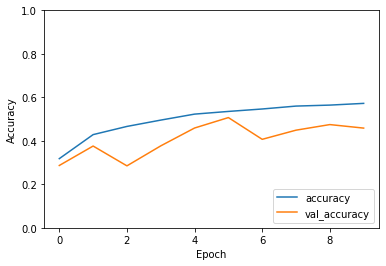

In [0]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = DenseNet_cifar_model_train_with_cifar.evaluate(test_images_cifar,  test_labels_cifar, verbose=2)

# **TensorBoard Computation Graphs with DenseNet on CIFAR-10**

---



In [0]:
import tensorboard
tensorboard.__version__
from google.colab import drive;
import numpy as np
import os

In [0]:
%load_ext tensorboard
#%tensorboard --logdir logs_1

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
os.getcwd()

'/content'

In [0]:
os.chdir('/content/drive/My Drive/Colab Notebooks')

In [0]:
import time
logdir = os.path.join("logs_ass_4", "Script1" )
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [0]:
DenseNet_cifar_model_train_with_cifar.fit(train_images_cifar, train_labels_cifar, epochs=5, batch_size=64,
                    validation_data=(test_images_cifar, test_labels_cifar), callbacks=[tensorboard_callback])

Epoch 1/5
782/782 [==============================] - 76s 97ms/step - loss: 2.5798 - accuracy: 0.3583 - val_loss: 2.3260 - val_accuracy: 0.3144
Epoch 2/5
782/782 [==============================] - 71s 90ms/step - loss: 2.1796 - accuracy: 0.4292 - val_loss: 2.2449 - val_accuracy: 0.3388
Epoch 3/5
782/782 [==============================] - 71s 90ms/step - loss: 2.1137 - accuracy: 0.4604 - val_loss: 2.1118 - val_accuracy: 0.4539
Epoch 4/5
782/782 [==============================] - 71s 91ms/step - loss: 2.0847 - accuracy: 0.4796 - val_loss: 2.1286 - val_accuracy: 0.4271
Epoch 5/5
782/782 [==============================] - 71s 91ms/step - loss: 2.0654 - accuracy: 0.4964 - val_loss: 2.0768 - val_accuracy: 0.4854


In [0]:
%tensorboard --logdir logs_ass_4

<IPython.core.display.Javascript object>

*   Tensorboard Graph functionality is freezing the graph.

